In [ ]:
# Import necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.cluster import KMeans

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss, recall_score, precision_score
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(5)
import time
plt.style.use('seaborn')

# **Load the Preprocessed Data**


In [ ]:
df = pd.read_csv('processed_marketing_campaign.csv')

In [ ]:
# Check the shape of dataset

print(df.shape)

(2236, 17)


In [ ]:
# Information of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NumDealsPurchases    2236 non-null   float64
 1   Age                  2236 non-null   float64
 2   MntMeatProducts      2236 non-null   float64
 3   MntFishProducts      2236 non-null   float64
 4   SweetPurchases       2236 non-null   float64
 5   Response             2236 non-null   int64  
 6   NumWebPurchases      2236 non-null   float64
 7   NumWebVisitsMonth    2236 non-null   float64
 8   Spent                2236 non-null   float64
 9   TotalAcceptedOffers  2236 non-null   float64
 10  NumCatalogPurchases  2236 non-null   float64
 11  Marital_Status       2236 non-null   int64  
 12  NumStorePurchases    2236 non-null   float64
 13  Kidhome              2236 non-null   float64
 14  Income               2236 non-null   float64
 15  MntGoldProds         2236 non-null   f

In [ ]:
# print data

df.head()

,NumDealsPurchases,Age,MntMeatProducts,MntFishProducts,SweetPurchases,Response,NumWebPurchases,NumWebVisitsMonth,Spent,TotalAcceptedOffers,NumCatalogPurchases,Marital_Status,NumStorePurchases,Kidhome,Income,MntGoldProds,Teenhome
0,0.200000,0.696429,0.316522,0.664093,0.465608,1,0.296296,0.35,0.565004,0.0,0.357143,0,0.307692,0.0,0.351086,0.243094,0
1,0.133333,0.750000,0.003478,0.007722,0.005291,0,0.037037,0.25,0.008014,0.0,0.035714,0,0.153846,0.5,0.277680,0.016575,1
2,0.066667,0.553571,0.073623,0.428571,0.185185,0,0.296296,0.20,0.268032,0.0,0.071429,1,0.769231,0.0,0.434956,0.116022,0
3,0.133333,0.214286,0.011594,0.038610,0.018519,0,0.074074,0.30,0.015583,0.0,0.000000,1,0.307692,0.5,0.155079,0.013812,0
4,0.333333,0.267857,0.068406,0.177606,0.185185,0,0.185185,0.25,0.148709,0.0,0.107143,1,0.461538,0.5,0.352051,0.041436,0


In [ ]:
# Separate the test dataset into target label and feature variables

X = df.drop('Teenhome', axis = 1)
y = df['Teenhome']

In [ ]:
X.head()

,NumDealsPurchases,Age,MntMeatProducts,MntFishProducts,SweetPurchases,Response,NumWebPurchases,NumWebVisitsMonth,Spent,TotalAcceptedOffers,NumCatalogPurchases,Marital_Status,NumStorePurchases,Kidhome,Income,MntGoldProds
0,0.200000,0.696429,0.316522,0.664093,0.465608,1,0.296296,0.35,0.565004,0.0,0.357143,0,0.307692,0.0,0.351086,0.243094
1,0.133333,0.750000,0.003478,0.007722,0.005291,0,0.037037,0.25,0.008014,0.0,0.035714,0,0.153846,0.5,0.277680,0.016575
2,0.066667,0.553571,0.073623,0.428571,0.185185,0,0.296296,0.20,0.268032,0.0,0.071429,1,0.769231,0.0,0.434956,0.116022
3,0.133333,0.214286,0.011594,0.038610,0.018519,0,0.074074,0.30,0.015583,0.0,0.000000,1,0.307692,0.5,0.155079,0.013812
4,0.333333,0.267857,0.068406,0.177606,0.185185,0,0.185185,0.25,0.148709,0.0,0.107143,1,0.461538,0.5,0.352051,0.041436


# **Machine Learning Models**

### Split the data into Train, Test and Unlabelled data

In [ ]:
df = pd.concat([X, y], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NumDealsPurchases    2236 non-null   float64
 1   Age                  2236 non-null   float64
 2   MntMeatProducts      2236 non-null   float64
 3   MntFishProducts      2236 non-null   float64
 4   SweetPurchases       2236 non-null   float64
 5   Response             2236 non-null   int64  
 6   NumWebPurchases      2236 non-null   float64
 7   NumWebVisitsMonth    2236 non-null   float64
 8   Spent                2236 non-null   float64
 9   TotalAcceptedOffers  2236 non-null   float64
 10  NumCatalogPurchases  2236 non-null   float64
 11  Marital_Status       2236 non-null   int64  
 12  NumStorePurchases    2236 non-null   float64
 13  Kidhome              2236 non-null   float64
 14  Income               2236 non-null   float64
 15  MntGoldProds         2236 non-null   f

In [ ]:
# Assign data to train, test, and unlabeled sets

def reset_holdout_splits(X,y, unlabelled_size,holdout_test_size=0.2): 

  X_holdout, X_unlabelled, y_holdout, y_unlabelled = train_test_split(X, y, 
                                                                     test_size=unlabelled_size, random_state=1, stratify=y)

  X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, test_size=holdout_test_size,
                                                      random_state=1, stratify=y_holdout)

  return X_train, y_train, X_test, y_test, X_unlabelled


### Self-Training Function

In [ ]:
def selfTraining(clf, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False): 
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        test_accuracy.append(test_acc)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        if auto_balancing:
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
          
          if not(is_balanced_data):
            sampler = SMOTE(sampling_strategy=1.0)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Co-Training Function

In [ ]:
def coTraining(clf1, clf2, view1, view2, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False):
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = {0: [], 1:[]}

    train_f1s = {0: [],1: []}

    test_f1s = {0: [],1: []}

    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # cotraining classifiers 
    clfs = [clf1, clf2]
    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
        
        # Fit classifier and make train/test predictions
        for i in [0,1]: 

            clf = clfs[i]

            if i == 0:
                X_train = X_train[view1]
                X_test = X_test[view1]
                X_unlabelled = X_unlabelled[view1]
            else: 
                X_train = X_train[view2]
                X_test = X_test[view2]
                X_unlabelled = X_unlabelled[view2]
            
            clf.fit(X_train, y_train)

            y_hat_train = clf.predict(X_train)
            y_hat_test = clf.predict(X_test)

            # Calculate and print iteration # and f1 scores, and store f1 scores
            test_acc = accuracy_score(y_test, y_hat_test)
            train_f1 = f1_score(y_train, y_hat_train)
            test_f1 = f1_score(y_test, y_hat_test)
            print(f"Iteration {iterations}, Classifier: {i}")
            print(f"Clf: {i}: Test Accuracy: {test_acc}")
            print(f"Clf: {i}: Train f1: {train_f1}")
            print(f"Clf: {i}: Test f1: {test_f1}")
            test_accuracy[i].append(test_acc)
            train_f1s[i].append(train_f1)
            test_f1s[i].append(test_f1)
            
            # Generate predictions and probabilities for unlabeled data
            print(f"Now predicting labels for unlabeled data...")

            pred_probs = clf.predict_proba(X_unlabelled)
            preds = clf.predict(X_unlabelled)
            prob_0 = pred_probs[:,0]
            prob_1 = pred_probs[:,1]

            # Store predictions and probabilities in dataframe
            df_pred_prob = pd.DataFrame([])
            df_pred_prob['preds'] = preds
            df_pred_prob['prob_0'] = prob_0
            df_pred_prob['prob_1'] = prob_1
            df_pred_prob.index = X_unlabelled.index
            
            # Separate predictions with > 99% probability
            high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                                    df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                                    axis=0)
            
            print(f"{len(high_prob)} high-probability predictions added to training data.")
            
            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
            y_train = pd.concat([y_train, high_prob.preds])  

            if auto_balancing:
              merged_df = pd.concat([X_train, y_train], axis=1)
              zero_count = len(y_train[y_train == 0])
              one_count = len(y_train[y_train == 1])

              is_balanced_data = False
              if zero_count == one_count:
                is_balanced_data = True
                
              if not(is_balanced_data):
                sampler = SMOTE(sampling_strategy=1)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            
            # Drop pseudo-labeled instances from unlabeled data
            X_unlabelled = X_unlabelled.drop(index=high_prob.index)
            print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
            
            if (len(high_prob)):
              break
            # Update iteration counter
            iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Boosting function (Assemble)

In [ ]:
def boosting_assemble(clf, X_train, y_train, X_unlabelled, X_test, y_test, margin, auto_balancing=False): 
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf = clf.fit(X_train,y_train)
        
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        test_accuracy.append(test_acc)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > margin],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > margin]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train =  pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds]) 
        
        if auto_balancing:
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
        
          if not(is_balanced_data):
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Unsupervised Clustering/Pre-processing function

In [ ]:
def unsupervised_labelling (clf, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False): 
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])
    y_combined.reset_index(drop=True, inplace=True)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_combined)

    X_new_feature = kmeans.labels_
    X_new_feature = pd.DataFrame(X_new_feature,columns=['cluster'])
    
    X_combined.reset_index(drop=True,inplace=True)
    X_new_feature.reset_index(drop=True,inplace=True)

    X_new = pd.concat([X_combined, X_new_feature],axis=1)
    
    Unlabelled_new_feature = kmeans.predict(X_unlabelled)
    Unlabelled_new_feature = pd.DataFrame(Unlabelled_new_feature, columns=['cluster'])
    X_unlabelled.reset_index(drop=True,inplace=True)
    Unlabelled_new_feature.reset_index(drop=True,inplace=True)

    X_unlabelled = pd.concat([X_unlabelled, Unlabelled_new_feature],axis=1)

    print(f"{X_new.shape} {y_combined.shape}")
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_combined, test_size=0.1, stratify=y_combined)
    
    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        test_accuracy.append(test_acc)

        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        if auto_balancing:
          print("doing balancing")
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
          
          if not(is_balanced_data):
            print("applying smote")
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

# 1. 100% labelled data - Fully Supervised learning - Imbalanced

### Gradient Boosting - Imbalanced

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

AxesSubplot(0.125,0.125;0.775x0.755)


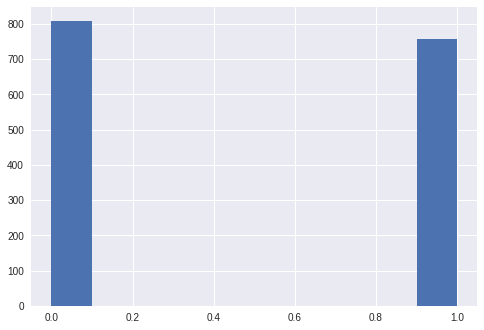

In [ ]:
print(y_train.hist())

In [ ]:
# Gradient Boosting Classifier for Binary classification
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', GradientBoostingClassifier())])

cv = KFold(n_splits=10)

params = [{'model__n_estimators':[101,200,301,151],
           'model__learning_rate': [0.1,0.01,0.2,10],
          'model__min_samples_split': [2,4,7],
          'model__min_samples_leaf': [1,3,7]}]

grid_search = GridSearchCV(
    estimator=pipe, param_grid=params, cv=cv, refit=True
)
grid_search.fit(X_train, y_train)
pred_gbc = grid_search.predict(X_test)

# calculate and display our base accuracy
acc_score = accuracy_score(y_test, pred_gbc)
gbc_score = f1_score (y_test, pred_gbc)
print("Accuracy-Score: %s" % acc_score)
print("F1-Score: %s" % gbc_score)

# print classification report 
print(classification_report(y_test, pred_gbc))

Accuracy-Score: 0.9195230998509687
F1-Score: 0.9164086687306501
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       347
           1       0.92      0.91      0.92       324

    accuracy                           0.92       671
   macro avg       0.92      0.92      0.92       671
weighted avg       0.92      0.92      0.92       671

CPU times: user 15min 44s, sys: 1.29 s, total: 15min 45s
Wall time: 15min 45s


In [ ]:
%%time
#{'model__learning_rate': 0.1, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 301}}
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=3,min_samples_split=2, n_estimators=301)
gbc.fit(X_train, y_train)
pred_gbc = gbc.predict(X_test)

# calculate and display our base accuracy
gbc_f1_score = f1_score(y_test, pred_gbc)
gbc_acc_score = accuracy_score(y_test, pred_gbc)
print("F1-Score: %s" % gbc_f1_score)
print("Accuracy-Score: %s" % gbc_acc_score)

# print classification report 
print(classification_report(y_test, pred_gbc))

F1-Score: 0.9149922720247295
Accuracy-Score: 0.9180327868852459
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       347
           1       0.92      0.91      0.91       324

    accuracy                           0.92       671
   macro avg       0.92      0.92      0.92       671
weighted avg       0.92      0.92      0.92       671

CPU times: user 1.14 s, sys: 2.28 ms, total: 1.14 s
Wall time: 1.14 s


In [ ]:
fpr_imb, tpr_imb, thresholds_imb = roc_curve(y_test, pred_gbc)
roc_auc_imb = auc(fpr_imb, tpr_imb)

### Gradient Boosting - Balanced

In [ ]:
smt = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = smt.fit_resample(X_train, y_train)
np.bincount(y_train_sampled)

array([808, 808])

In [ ]:
X_train_sampled = pd.DataFrame(X_train_sampled)
y_train_sampled = pd.DataFrame(y_train_sampled)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93c33a2990>]],
      dtype=object)

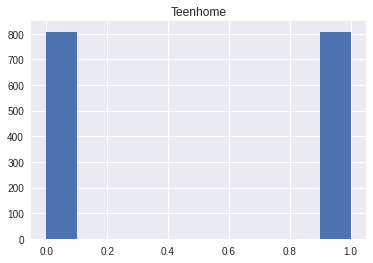

In [ ]:
y_train_sampled.hist()

In [ ]:
y_train_temp = y_train_sampled.values
y_train_sampled = np.ravel(y_train_temp)
y_train_sampled.shape

(1616,)

In [ ]:
%%time
gbc = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=3,min_samples_split=2, n_estimators=301)
gbc.fit(X_train_sampled, y_train_sampled)
pred_gbc = gbc.predict(X_test)

# calculate and display our base accuracy
gbc_f1_score = f1_score(y_test, pred_gbc)
gbc_acc_score = accuracy_score(y_test, pred_gbc)
print("F1-Score: %s" % gbc_f1_score)
print("Accuracy Score: %s"%gbc_acc_score)

# print classification report 
print(classification_report(y_test, pred_gbc))

F1-Score: 0.9096573208722741
Accuracy Score: 0.9135618479880775
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       347
           1       0.92      0.90      0.91       324

    accuracy                           0.91       671
   macro avg       0.91      0.91      0.91       671
weighted avg       0.91      0.91      0.91       671

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.2 s


In [ ]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test, pred_gbc)
roc_auc_bal = auc(fpr_bal, tpr_bal)

# 2. 10% unlabelled, 90% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_10_imb, st_f1_10_imb, st_10_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8833746898263027
Train f1: 0.9591836734693878
Test f1: 0.8785529715762275
Now predicting labels for unlabeled data...
42 high-probability predictions added to training data.
182 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8833746898263027
Train f1: 0.961006289308176
Test f1: 0.8797953964194374
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
174 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8883374689826302
Train f1: 0.9594510293200249
Test f1: 0.8849104859335039
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
169 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8833746898263027
Train f1: 0.9628697293895532
Test f1: 0.8791773778920308
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
168 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8833746898263027
Tr

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_10_bal, st_f1_10_bal, st_10_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8808933002481389
Train f1: 0.9612698412698413
Test f1: 0.8775510204081632
Now predicting labels for unlabeled data...
41 high-probability predictions added to training data.
183 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.890818858560794
Train f1: 0.9627507163323782
Test f1: 0.8865979381443297
Now predicting labels for unlabeled data...
13 high-probability predictions added to training data.
170 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8858560794044665
Train f1: 0.9648127128263337
Test f1: 0.882051282051282
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
166 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.890818858560794
Train f1: 0.9661399548532731
Test f1: 0.8877551020408163
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
165 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8784119106699751
Tra

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_10_imb, ct_f1_10_imb, ct_10_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.9156327543424317
Clf: 0: Train f1: 0.9333333333333333
Clf: 0: Test f1: 0.9119170984455959
Now predicting labels for unlabeled data...
100 high-probability predictions added to training data.
124 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.9156327543424317
Clf: 0: Train f1: 0.937080024434942
Clf: 0: Test f1: 0.9119170984455959
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
124 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8759305210918115
Clf: 1: Train f1: 0.9597113650030067
Clf: 1: Test f1: 0.8697916666666666
Now predicting labels for unlabeled data...
11 high-probability predictions added to training data.
113 unlabeled instances remaining.

Iteration 1, Classifier: 0
Clf: 0: Test Accuracy: 0.913151364764268
Clf: 0: Train f1: 0.9365079365079365
Clf: 0: Test f1: 0.9095607235142118
Now predicting labels for 

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_10_bal, ct_f1_10_bal, ct_10_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.9156327543424317
Clf: 0: Train f1: 0.9333333333333333
Clf: 0: Test f1: 0.9119170984455959
Now predicting labels for unlabeled data...
105 high-probability predictions added to training data.
119 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.913151364764268
Clf: 0: Train f1: 0.9426321709786277
Clf: 0: Test f1: 0.910025706940874
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
116 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.9156327543424317
Clf: 0: Train f1: 0.9433538979248459
Clf: 0: Test f1: 0.9123711340206185
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
111 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.9156327543424317
Clf: 0: Train f1: 0.943606923506421
Clf: 0: Test f1: 0.9123711340206185
Now predicting labels for un

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_10_imb, sse_f1_10_imb, sse_10_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.9205955334987593
Train f1: 0.9367741935483871
Test f1: 0.9166666666666667
Now predicting labels for unlabeled data...
90 high-probability predictions added to training data.
134 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9181141439205955
Train f1: 0.9387755102040817
Test f1: 0.9142857142857141
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
130 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9081885856079405
Train f1: 0.9406674907292955
Test f1: 0.9043927648578811
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
126 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9156327543424317
Train f1: 0.935064935064935
Test f1: 0.9109947643979058
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
126 unlabeled instances remaining.

CPU times: user 690 ms, sys: 27.3 ms, total: 718

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_10_bal, sse_f1_10_bal, sse_10_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.9205955334987593
Train f1: 0.9367741935483871
Test f1: 0.9166666666666667
Now predicting labels for unlabeled data...
90 high-probability predictions added to training data.
134 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9081885856079405
Train f1: 0.9443507588532883
Test f1: 0.9048843187660668
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
129 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9007444168734491
Train f1: 0.9450056116722783
Test f1: 0.8969072164948454
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
125 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9081885856079405
Train f1: 0.9473684210526316
Test f1: 0.9048843187660668
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
124 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.913151364764268
Tr

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.1, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_10_imb, usl_f1_10_imb, usl_10_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(2012, 17) (2012,)
Iteration 0
Test Accuracy: 0.8960396039603961
Train f1: 0.9659090909090909
Test f1: 0.8944723618090452
Now predicting labels for unlabeled data...
41 high-probability predictions added to training data.
183 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8712871287128713
Train f1: 0.964824120603015
Test f1: 0.8686868686868686
Now predicting labels for unlabeled data...
12 high-probability predictions added to training data.
171 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8861386138613861
Train f1: 0.965864577504197
Test f1: 0.8844221105527638
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
167 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8910891089108911
Train f1: 0.9664804469273743
Test f1: 0.89
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
167 unlabeled instances remaining.

CPU times: user 3.03 s, sys: 551 ms, total:

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_10_bal, usl_f1_10_bal, usl_10_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(2012, 17) (2012,)
Iteration 0
Test Accuracy: 0.8613861386138614
Train f1: 0.9620826259196379
Test f1: 0.8571428571428571
Now predicting labels for unlabeled data...
47 high-probability predictions added to training data.
doing balancing
applying smote
177 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8564356435643564
Train f1: 0.9684317718940937
Test f1: 0.8527918781725888
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
doing balancing
applying smote
173 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8663366336633663
Train f1: 0.9648854961832061
Test f1: 0.8601036269430051
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
doing balancing
applying smote
168 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8415841584158416
Train f1: 0.9671219018715226
Test f1: 0.8383838383838385
Now predicting labels for unlabeled data...
2 high-probability predict

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
df = pd.concat([X,y],axis=1)
abs(df.corr()['Teenhome'])

NumDealsPurchases      0.394803
Age                    0.368572
MntMeatProducts        0.275858
MntFishProducts        0.210854
SweetPurchases         0.195425
Response               0.161871
NumWebPurchases        0.157856
NumWebVisitsMonth      0.142853
Spent                  0.134999
TotalAcceptedOffers    0.124528
NumCatalogPurchases    0.116324
Marital_Status         0.101892
NumStorePurchases      0.048166
Kidhome                0.036687
Income                 0.029775
MntGoldProds           0.023137
Teenhome               1.000000
Name: Teenhome, dtype: float64

In [ ]:
selected_features = ['NumDealsPurchases', 'Age', 'MntMeatProducts', 'MntFishProducts', 'SweetPurchases', 'Response']
X_intrinsic = X[selected_features]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_scaled_int = StandardScaler().fit_transform(X_intrinsic)
X_scaled_int = pd.DataFrame(X_scaled_int,columns=X_intrinsic.columns)

In [ ]:
%%time
# split data into labeled and unlabeled
X_scaled = StandardScaler().fit_transform(X)

X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled , y, test_size=0.10, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1609, 16) (1609,)
Unlabeled Train Set: (224, 16) (224,)
Test Set: (403, 16) (403,)
CPU times: user 11.1 ms, sys: 1 ms, total: 12.1 ms
Wall time: 12.2 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb8c09a790>]],
      dtype=object)

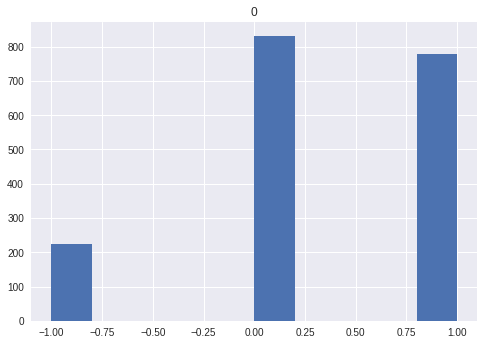

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_10_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_10_model_imb.classes_)
print(intrinsic_10_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.7599563557010366
CPU times: user 299 ms, sys: 238 ms, total: 537 ms
Wall time: 307 ms


In [ ]:
y_pred = intrinsic_10_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8808933002481389
0.8787878787878788


In [ ]:
fpr_int_10_imb, tpr_int_10_imb, thresholds_int_10_imb = roc_curve(y_test, y_pred)
auc_int_10_imb = auc(fpr_int_10_imb, tpr_int_10_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled , y, test_size=0.10, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1662, 16) (1662,)
Unlabeled Train Set: (224, 16) (224,)
Test Set: (403, 16) (403,)
CPU times: user 35.5 ms, sys: 14 ms, total: 49.5 ms
Wall time: 49.4 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb8c0f8310>]],
      dtype=object)

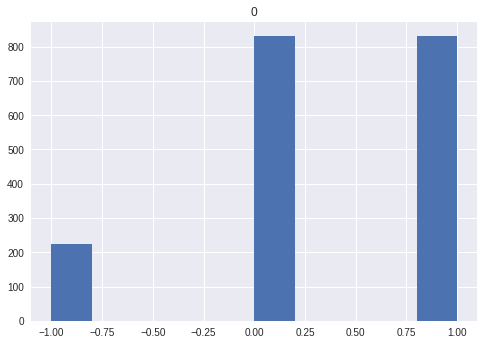

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_10_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_10_model_bal.classes_)
print(intrinsic_10_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.7629904559915165
CPU times: user 285 ms, sys: 187 ms, total: 472 ms
Wall time: 277 ms


In [ ]:
y_pred = intrinsic_10_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8734491315136477
0.8721804511278195


In [ ]:
fpr_int_10_bal, tpr_int_10_bal, thresholds_int_10_bal = roc_curve(y_test, y_pred)
auc_int_10_bal = auc(fpr_int_10_bal, tpr_int_10_bal)

# 3. 20% unlabelled, 80% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_20_imb, st_f1_20_imb, st_20_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8994413407821229
Train f1: 0.9671428571428572
Test f1: 0.897142857142857
Now predicting labels for unlabeled data...
99 high-probability predictions added to training data.
349 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8910614525139665
Train f1: 0.96673455532926
Test f1: 0.8895184135977338
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
329 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8938547486033519
Train f1: 0.968178740690589
Test f1: 0.8914285714285713
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
321 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8994413407821229
Train f1: 0.9718120805369128
Test f1: 0.897142857142857
Now predicting labels for unlabeled data...
11 high-probability predictions added to training data.
310 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8994413407821229
Trai

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_20_bal, st_f1_20_bal, st_20_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.890818858560794
Train f1: 0.9587301587301588
Test f1: 0.8877551020408163
Now predicting labels for unlabeled data...
43 high-probability predictions added to training data.
181 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8883374689826302
Train f1: 0.9621559633027523
Test f1: 0.883720930232558
Now predicting labels for unlabeled data...
10 high-probability predictions added to training data.
171 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8933002481389578
Train f1: 0.9623717217787914
Test f1: 0.8883116883116884
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
167 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8784119106699751
Train f1: 0.9647727272727272
Test f1: 0.8740359897172237
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
165 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8808933002481389
Tr

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_20_imb, ct_f1_20_imb, ct_20_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8910614525139665
Clf: 0: Train f1: 0.935740072202166
Clf: 0: Test f1: 0.8895184135977338
Now predicting labels for unlabeled data...
217 high-probability predictions added to training data.
231 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8910614525139665
Clf: 0: Train f1: 0.9439899307740717
Clf: 0: Test f1: 0.8895184135977338
Now predicting labels for unlabeled data...
10 high-probability predictions added to training data.
221 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8910614525139665
Clf: 0: Train f1: 0.9442705072010019
Clf: 0: Test f1: 0.8895184135977338
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
221 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8910614525139665
Clf: 1: Train f1: 0.9669369931378665
Clf: 1: Test f1: 0.8882521489971347
Now predicting labels for

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_20_bal, ct_f1_20_bal, ct_20_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8910614525139665
Clf: 0: Train f1: 0.935740072202166
Clf: 0: Test f1: 0.8895184135977338
Now predicting labels for unlabeled data...
214 high-probability predictions added to training data.
234 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8966480446927374
Clf: 0: Train f1: 0.9475524475524475
Clf: 0: Test f1: 0.8951841359773371
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
226 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8966480446927374
Clf: 0: Train f1: 0.9491329479768786
Clf: 0: Test f1: 0.8951841359773371
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
218 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8966480446927374
Clf: 0: Train f1: 0.9493670886075949
Clf: 0: Test f1: 0.8951841359773371
Now predicting labels for 

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_20_imb, sse_f1_20_imb, sse_20_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.9134078212290503
Train f1: 0.9395484340859432
Test f1: 0.9106628242074928
Now predicting labels for unlabeled data...
188 high-probability predictions added to training data.
260 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9134078212290503
Train f1: 0.9486842105263158
Test f1: 0.9111747851002866
Now predicting labels for unlabeled data...
13 high-probability predictions added to training data.
247 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9106145251396648
Train f1: 0.9488859764089123
Test f1: 0.9085714285714287
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
244 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9162011173184358
Train f1: 0.9432485322896281
Test f1: 0.9142857142857141
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
242 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.9134078212290503

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_20_bal, sse_f1_20_bal, sse_20_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.9134078212290503
Train f1: 0.9395484340859432
Test f1: 0.9106628242074928
Now predicting labels for unlabeled data...
188 high-probability predictions added to training data.
260 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9162011173184358
Train f1: 0.9530516431924883
Test f1: 0.9142857142857141
Now predicting labels for unlabeled data...
19 high-probability predictions added to training data.
241 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9162011173184358
Train f1: 0.9524913093858632
Test f1: 0.9142857142857141
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
238 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9134078212290503
Train f1: 0.9510650546919978
Test f1: 0.9111747851002866
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
233 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.9217877094972067

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.2, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_20_imb, usl_f1_20_imb, usl_20_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(1788, 17) (1788,)
Iteration 0
Test Accuracy: 0.9050279329608939
Train f1: 0.9598470363288718
Test f1: 0.9017341040462429
Now predicting labels for unlabeled data...
80 high-probability predictions added to training data.
368 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9050279329608939
Train f1: 0.9641975308641975
Test f1: 0.9005847953216374
Now predicting labels for unlabeled data...
16 high-probability predictions added to training data.
352 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9106145251396648
Train f1: 0.9630541871921182
Test f1: 0.9069767441860465
Now predicting labels for unlabeled data...
12 high-probability predictions added to training data.
340 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9162011173184358
Train f1: 0.9669926650366748
Test f1: 0.9112426035502958
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
332 unlabeled instances remaining.

Iteration 4
Test Accuracy:

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.2, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_20_bal, usl_f1_20_bal, usl_20_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(1788, 17) (1788,)
Iteration 0
Test Accuracy: 0.9050279329608939
Train f1: 0.9593392630241424
Test f1: 0.8994082840236686
Now predicting labels for unlabeled data...
89 high-probability predictions added to training data.
doing balancing
applying smote
359 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9106145251396648
Train f1: 0.9651355838406198
Test f1: 0.9058823529411765
Now predicting labels for unlabeled data...
24 high-probability predictions added to training data.
doing balancing
applying smote
335 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9162011173184358
Train f1: 0.9672489082969431
Test f1: 0.9122807017543859
Now predicting labels for unlabeled data...
11 high-probability predictions added to training data.
doing balancing
applying smote
324 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9050279329608939
Train f1: 0.9651795429815017
Test f1: 0.8994082840236686
Now predicting labels for unlabeled data...
11 high-probability pred

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.20, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1430, 6) (1430,)
Unlabeled Train Set: (448, 6) (448,)
Test Set: (358, 6) (358,)
CPU times: user 8.09 ms, sys: 997 µs, total: 9.09 ms
Wall time: 9.44 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83ef25d0>]],
      dtype=object)

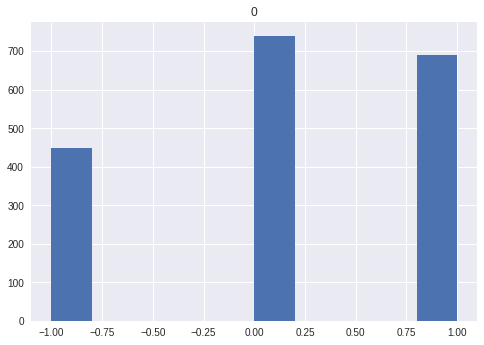

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_20_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_20_model_imb.classes_)
print(intrinsic_20_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.6309904153354633
CPU times: user 88.7 ms, sys: 1 ms, total: 89.7 ms
Wall time: 97 ms


In [ ]:
y_pred = intrinsic_20_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8435754189944135
0.8444444444444443


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_20_imb, tpr_int_20_imb, thresholds_int_20_imb = roc_curve(y_test, y_pred)
auc_int_20_imb = auc(fpr_int_20_imb, tpr_int_20_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.20, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1478, 6) (1478,)
Unlabeled Train Set: (448, 6) (448,)
Test Set: (358, 6) (358,)
CPU times: user 16.7 ms, sys: 3 µs, total: 16.7 ms
Wall time: 16.5 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83f13750>]],
      dtype=object)

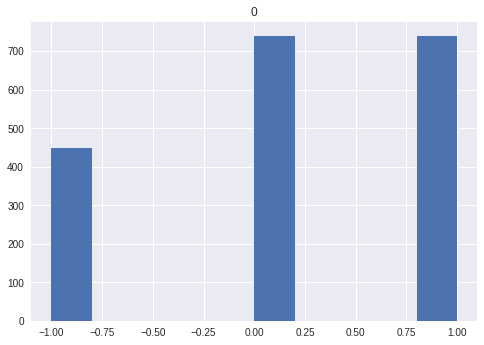

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_20_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_20_model_bal.classes_)
print(intrinsic_20_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.6360332294911735
CPU times: user 83.9 ms, sys: 0 ns, total: 83.9 ms
Wall time: 86 ms


In [ ]:
y_pred = intrinsic_20_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8435754189944135
0.8453038674033149


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_20_bal, tpr_int_20_bal, thresholds_int_20_bal = roc_curve(y_test, y_pred)
auc_int_20_bal = auc(fpr_int_20_bal, tpr_int_20_bal)

# 4. 50% unlabelled, 50% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_50_imb, st_f1_50_imb, st_50_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8883928571428571
Train f1: 0.9690011481056258
Test f1: 0.8858447488584474
Now predicting labels for unlabeled data...
210 high-probability predictions added to training data.
908 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.875
Train f1: 0.976303317535545
Test f1: 0.8715596330275229
Now predicting labels for unlabeled data...
65 high-probability predictions added to training data.
843 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8705357142857143
Train f1: 0.9774571686203788
Test f1: 0.867579908675799
Now predicting labels for unlabeled data...
25 high-probability predictions added to training data.
818 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8794642857142857
Train f1: 0.9762114537444935
Test f1: 0.8755760368663594
Now predicting labels for unlabeled data...
23 high-probability predictions added to training data.
795 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8660714285714286
Train f1: 0.

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_50_bal, st_f1_50_bal, st_50_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8839285714285714
Train f1: 0.9690011481056258
Test f1: 0.8828828828828829
Now predicting labels for unlabeled data...
221 high-probability predictions added to training data.
897 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8839285714285714
Train f1: 0.978114478114478
Test f1: 0.8818181818181818
Now predicting labels for unlabeled data...
58 high-probability predictions added to training data.
839 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.875
Train f1: 0.9767814251401121
Test f1: 0.8727272727272727
Now predicting labels for unlabeled data...
31 high-probability predictions added to training data.
808 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.875
Train f1: 0.9796874999999999
Test f1: 0.8727272727272727
Now predicting labels for unlabeled data...
16 high-probability predictions added to training data.
792 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.875
Train f1: 0.9768875192604005
Test f1:

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_50_imb, ct_f1_50_imb, ct_50_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9351851851851852
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels for unlabeled data...
506 high-probability predictions added to training data.
612 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9587628865979382
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels for unlabeled data...
56 high-probability predictions added to training data.
556 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9603399433427762
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels for unlabeled data...
24 high-probability predictions added to training data.
532 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9610027855153204
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels f

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_50_bal, ct_f1_50_bal, ct_50_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9351851851851852
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels for unlabeled data...
531 high-probability predictions added to training data.
587 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8526785714285714
Clf: 0: Train f1: 0.9603760913364674
Clf: 0: Test f1: 0.847926267281106
Now predicting labels for unlabeled data...
41 high-probability predictions added to training data.
546 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9588688946015425
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels for unlabeled data...
52 high-probability predictions added to training data.
494 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8616071428571429
Clf: 0: Train f1: 0.9597523219814241
Clf: 0: Test f1: 0.8558139534883722
Now predicting labels fo

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_50_imb, sse_f1_50_imb, sse_50_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.8973214285714286
Train f1: 0.9502890173410405
Test f1: 0.8949771689497718
Now predicting labels for unlabeled data...
469 high-probability predictions added to training data.
649 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9017857142857143
Train f1: 0.9575660528422738
Test f1: 0.8999999999999999
Now predicting labels for unlabeled data...
79 high-probability predictions added to training data.
570 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8973214285714286
Train f1: 0.9594694178334563
Test f1: 0.8959276018099547
Now predicting labels for unlabeled data...
16 high-probability predictions added to training data.
554 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8973214285714286
Train f1: 0.9600000000000001
Test f1: 0.8959276018099547
Now predicting labels for unlabeled data...
15 high-probability predictions added to training data.
539 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.89285714285714

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_50_bal, sse_f1_50_bal, sse_50_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.8973214285714286
Train f1: 0.9502890173410405
Test f1: 0.8949771689497718
Now predicting labels for unlabeled data...
469 high-probability predictions added to training data.
649 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8973214285714286
Train f1: 0.9668695064232589
Test f1: 0.8959276018099547
Now predicting labels for unlabeled data...
93 high-probability predictions added to training data.
556 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8928571428571429
Train f1: 0.9662499999999999
Test f1: 0.8909090909090909
Now predicting labels for unlabeled data...
29 high-probability predictions added to training data.
527 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8883928571428571
Train f1: 0.966686856450636
Test f1: 0.8878923766816144
Now predicting labels for unlabeled data...
17 high-probability predictions added to training data.
510 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.883928571428571

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.5, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_50_imb, usl_f1_50_imb, usl_50_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(1118, 17) (1118,)
Iteration 0
Test Accuracy: 0.9107142857142857
Train f1: 0.9693251533742332
Test f1: 0.9107142857142858
Now predicting labels for unlabeled data...
186 high-probability predictions added to training data.
932 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8839285714285714
Train f1: 0.9685534591194969
Test f1: 0.8828828828828829
Now predicting labels for unlabeled data...
89 high-probability predictions added to training data.
843 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8928571428571429
Train f1: 0.9767441860465116
Test f1: 0.8928571428571429
Now predicting labels for unlabeled data...
27 high-probability predictions added to training data.
816 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8928571428571429
Train f1: 0.9724473257698542
Test f1: 0.8947368421052632
Now predicting labels for unlabeled data...
14 high-probability predictions added to training data.
802 unlabeled instances remaining.

Iteration 4
Test Accurac

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_50_bal, usl_f1_50_bal, usl_50_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(1118, 17) (1118,)
Iteration 0
Test Accuracy: 0.8125
Train f1: 0.9744114636642783
Test f1: 0.8108108108108109
Now predicting labels for unlabeled data...
194 high-probability predictions added to training data.
doing balancing
applying smote
924 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.7946428571428571
Train f1: 0.9759503491078355
Test f1: 0.7964601769911505
Now predicting labels for unlabeled data...
87 high-probability predictions added to training data.
doing balancing
applying smote
837 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8035714285714286
Train f1: 0.9776817854571634
Test f1: 0.8035714285714286
Now predicting labels for unlabeled data...
18 high-probability predictions added to training data.
doing balancing
applying smote
819 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8125
Train f1: 0.9794762915782024
Test f1: 0.8073394495412846
Now predicting labels for unlabeled data...
20 high-probability predictions added to traini

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled , y, test_size=0.50, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (894, 16) (894,)
Unlabeled Train Set: (1118, 16) (1118,)
Test Set: (224, 16) (224,)
CPU times: user 9.16 ms, sys: 1 µs, total: 9.16 ms
Wall time: 9.56 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83e22c10>]],
      dtype=object)

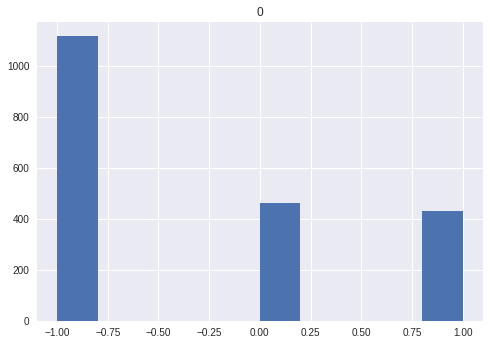

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_50_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_50_model_imb.classes_)
print(intrinsic_50_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.3841948310139165
CPU times: user 257 ms, sys: 235 ms, total: 492 ms
Wall time: 261 ms


In [ ]:
y_pred = intrinsic_50_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8214285714285714
0.8130841121495328


In [ ]:
fpr_int_50_imb, tpr_int_50_imb, thresholds_int_50_imb = roc_curve(y_test, y_pred)
auc_int_50_imb = auc(fpr_int_50_imb, tpr_int_50_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled , y, test_size=0.50, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (924, 16) (924,)
Unlabeled Train Set: (1118, 16) (1118,)
Test Set: (224, 16) (224,)
CPU times: user 22.7 ms, sys: 12 ms, total: 34.7 ms
Wall time: 23.7 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83d2a650>]],
      dtype=object)

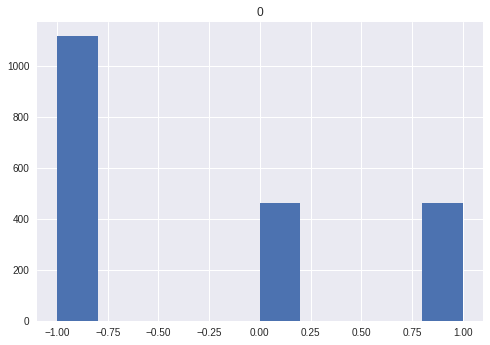

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_50_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_50_model_bal.classes_)
print(intrinsic_50_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.39275220372184133
CPU times: user 298 ms, sys: 189 ms, total: 487 ms
Wall time: 314 ms


In [ ]:
y_pred = intrinsic_50_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8214285714285714
0.8148148148148148


In [ ]:
fpr_int_50_bal, tpr_int_50_bal, thresholds_int_50_bal = roc_curve(y_test, y_pred)
auc_int_50_bal = auc(fpr_int_50_bal, tpr_int_50_bal)

# 5. 90% unlabelled, 10% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_90_imb, st_f1_90_imb, st_90_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.7333333333333333
Train f1: 0.9883720930232558
Test f1: 0.7272727272727273
Now predicting labels for unlabeled data...
191 high-probability predictions added to training data.
1822 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.7333333333333333
Train f1: 0.9861751152073732
Test f1: 0.7272727272727273
Now predicting labels for unlabeled data...
104 high-probability predictions added to training data.
1718 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8
Train f1: 0.9962264150943396
Test f1: 0.8
Now predicting labels for unlabeled data...
89 high-probability predictions added to training data.
1629 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.7777777777777778
Train f1: 0.9968454258675079
Test f1: 0.7727272727272727
Now predicting labels for unlabeled data...
96 high-probability predictions added to training data.
1533 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8
Train f1: 0.9976359338061466
Test f1:

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_90_bal, st_f1_90_bal, st_90_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.7555555555555555
Train f1: 0.9883720930232558
Test f1: 0.7555555555555555
Now predicting labels for unlabeled data...
219 high-probability predictions added to training data.
1794 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.7333333333333333
Train f1: 0.9930313588850175
Test f1: 0.7391304347826088
Now predicting labels for unlabeled data...
238 high-probability predictions added to training data.
1556 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.7111111111111111
Train f1: 0.9931192660550459
Test f1: 0.711111111111111
Now predicting labels for unlabeled data...
163 high-probability predictions added to training data.
1393 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.7555555555555555
Train f1: 0.9935004642525533
Test f1: 0.7555555555555555
Now predicting labels for unlabeled data...
87 high-probability predictions added to training data.
1306 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.777777777

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_90_imb, ct_f1_90_imb, ct_90_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9540229885057472
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
385 high-probability predictions added to training data.
1628 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9878787878787878
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
327 high-probability predictions added to training data.
1301 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9921104536489153
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
222 high-probability predictions added to training data.
1079 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9932203389830508
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
175 high-probability predictions a

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_90_bal, ct_f1_90_bal, ct_90_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9540229885057472
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
431 high-probability predictions added to training data.
1582 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9879879879879879
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
391 high-probability predictions added to training data.
1191 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9925093632958801
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
271 high-probability predictions added to training data.
920 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8
Clf: 0: Train f1: 0.9940476190476191
Clf: 0: Test f1: 0.7692307692307693
Now predicting labels for unlabeled data...
145 high-probability predictions ad

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_90_imb, sse_f1_90_imb, sse_90_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.7555555555555555
Train f1: 0.9941520467836257
Test f1: 0.7555555555555555
Now predicting labels for unlabeled data...
885 high-probability predictions added to training data.
1128 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.7555555555555555
Train f1: 0.9988385598141696
Test f1: 0.7555555555555555
Now predicting labels for unlabeled data...
440 high-probability predictions added to training data.
688 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.7777777777777778
Train f1: 0.9947089947089947
Test f1: 0.7727272727272727
Now predicting labels for unlabeled data...
135 high-probability predictions added to training data.
553 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.7777777777777778
Train f1: 0.9938817131203264
Test f1: 0.7727272727272727
Now predicting labels for unlabeled data...
88 high-probability predictions added to training data.
465 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.77777777777

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_90_bal, sse_f1_90_bal, sse_90_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.7555555555555555
Train f1: 0.9941520467836257
Test f1: 0.7555555555555555
Now predicting labels for unlabeled data...
885 high-probability predictions added to training data.
1128 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.7555555555555555
Train f1: 0.9968404423380727
Test f1: 0.7555555555555555
Now predicting labels for unlabeled data...
476 high-probability predictions added to training data.
652 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.7777777777777778
Train f1: 0.9961132704053304
Test f1: 0.7727272727272727
Now predicting labels for unlabeled data...
133 high-probability predictions added to training data.
519 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.7777777777777778
Train f1: 0.9953822473063109
Test f1: 0.7727272727272727
Now predicting labels for unlabeled data...
81 high-probability predictions added to training data.
438 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.77777777777

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.9, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_90_imb, usl_f1_90_imb, usl_90_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(223, 17) (223,)
Iteration 0
Test Accuracy: 0.7391304347826086
Train f1: 0.989795918367347
Test f1: 0.6666666666666665
Now predicting labels for unlabeled data...
198 high-probability predictions added to training data.
1815 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.7391304347826086
Train f1: 0.9931972789115647
Test f1: 0.6666666666666665
Now predicting labels for unlabeled data...
152 high-probability predictions added to training data.
1663 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.7391304347826086
Train f1: 0.9922879177377892
Test f1: 0.6666666666666665
Now predicting labels for unlabeled data...
75 high-probability predictions added to training data.
1588 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.6956521739130435
Train f1: 0.9956331877729258
Test f1: 0.631578947368421
Now predicting labels for unlabeled data...
52 high-probability predictions added to training data.
1536 unlabeled instances remaining.

Iteration 4
Test Accura

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_90_bal, usl_f1_90_bal, usl_90_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(223, 17) (223,)
Iteration 0
Test Accuracy: 0.9565217391304348
Train f1: 0.979381443298969
Test f1: 0.9565217391304348
Now predicting labels for unlabeled data...
135 high-probability predictions added to training data.
doing balancing
applying smote
1878 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9565217391304348
Train f1: 0.9864253393665159
Test f1: 0.9565217391304348
Now predicting labels for unlabeled data...
168 high-probability predictions added to training data.
doing balancing
applying smote
1710 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9565217391304348
Train f1: 0.993485342019544
Test f1: 0.9565217391304348
Now predicting labels for unlabeled data...
126 high-probability predictions added to training data.
doing balancing
applying smote
1584 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9565217391304348
Train f1: 0.9935483870967742
Test f1: 0.9565217391304348
Now predicting labels for unlabeled data...
78 high-probability pr

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.90, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (178, 6) (178,)
Unlabeled Train Set: (2013, 6) (2013,)
Test Set: (45, 6) (45,)
CPU times: user 7.03 ms, sys: 1 µs, total: 7.03 ms
Wall time: 7.04 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83d9ff90>]],
      dtype=object)

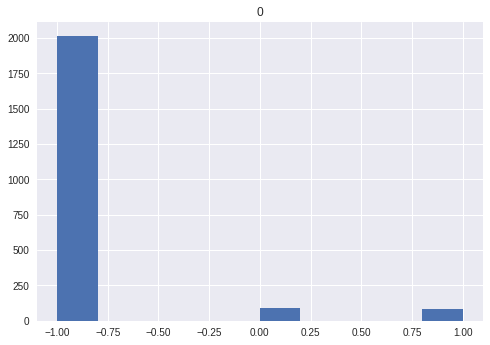

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_90_model_imb = LabelSpreading().fit(X_train_mixed, y_train_mixed)
print(intrinsic_90_model_imb.classes_)
print(intrinsic_90_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.07895937927886809
CPU times: user 648 ms, sys: 275 ms, total: 923 ms
Wall time: 610 ms


In [ ]:
y_pred = intrinsic_90_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.7111111111111111
0.711111111111111


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_90_imb, tpr_int_90_imb, thresholds_int_90_imb = roc_curve(y_test, y_pred)
auc_int_90_imb = auc(fpr_int_90_imb, tpr_int_90_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.90, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (184, 6) (184,)
Unlabeled Train Set: (2013, 6) (2013,)
Test Set: (45, 6) (45,)
CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 17.6 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb8c653c50>]],
      dtype=object)

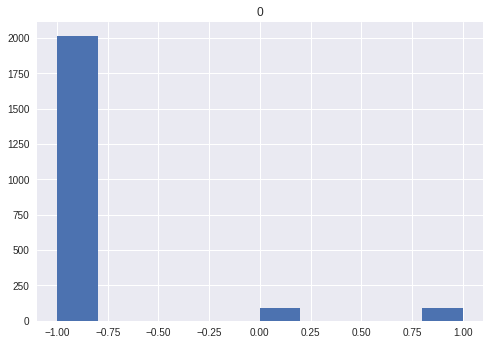

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_90_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_90_model_bal.classes_)
print(intrinsic_90_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.07464724624487938
CPU times: user 111 ms, sys: 2.06 ms, total: 114 ms
Wall time: 133 ms


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_90_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.6888888888888889
0.6956521739130435


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_90_bal, tpr_int_90_bal, thresholds_int_90_bal = roc_curve(y_test, y_pred)
auc_int_90_bal = auc(fpr_int_90_bal, tpr_int_90_bal)

# 6. 95% unlabelled, 5% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_95_imb, st_f1_95_imb, st_95_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8695652173913043
Train f1: 1.0
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
74 high-probability predictions added to training data.
2051 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8695652173913043
Train f1: 1.0
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
193 high-probability predictions added to training data.
1858 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8260869565217391
Train f1: 0.9965156794425087
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
159 high-probability predictions added to training data.
1699 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8260869565217391
Train f1: 0.9974937343358395
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
63 high-probability predictions added to training data.
1636 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.782608695652174
Train f1: 1.0
Test f1: 

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_95_bal, st_f1_95_bal, st_95_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8695652173913043
Train f1: 1.0
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
62 high-probability predictions added to training data.
2063 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8695652173913043
Train f1: 0.9938650306748467
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
199 high-probability predictions added to training data.
1864 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8695652173913043
Train f1: 1.0
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
141 high-probability predictions added to training data.
1723 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.782608695652174
Train f1: 0.9983136593591906
Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
66 high-probability predictions added to training data.
1657 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8260869565217391
Train f1: 0.99850968703

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_95_imb, ct_f1_95_imb, ct_95_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.782608695652174
Clf: 0: Train f1: 0.9647058823529412
Clf: 0: Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
105 high-probability predictions added to training data.
2020 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.782608695652174
Clf: 0: Train f1: 0.9873417721518987
Clf: 0: Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
251 high-probability predictions added to training data.
1769 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.782608695652174
Clf: 0: Train f1: 0.9948542024013721
Clf: 0: Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
356 high-probability predictions added to training data.
1413 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.782608695652174
Clf: 0: Train f1: 0.9970267591674925
Clf: 0: Test f1: 0.7368421052631579
Now predicting labels 

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_95_bal, ct_f1_95_bal, ct_95_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.782608695652174
Clf: 0: Train f1: 0.9647058823529412
Clf: 0: Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
273 high-probability predictions added to training data.
1852 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.7391304347826086
Clf: 0: Train f1: 0.9933481152993349
Clf: 0: Test f1: 0.6666666666666665
Now predicting labels for unlabeled data...
366 high-probability predictions added to training data.
1486 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.7391304347826086
Clf: 0: Train f1: 0.9966329966329966
Clf: 0: Test f1: 0.6666666666666665
Now predicting labels for unlabeled data...
442 high-probability predictions added to training data.
1044 unlabeled instances remaining.

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.7391304347826086
Clf: 0: Train f1: 0.9978947368421052
Clf: 0: Test f1: 0.6666666666666665
Now predicting labe

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_95_imb, sse_f1_95_imb, sse_95_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.8695652173913043
Train f1: 1.0
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
940 high-probability predictions added to training data.
1185 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8260869565217391
Train f1: 1.0
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
521 high-probability predictions added to training data.
664 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.782608695652174
Train f1: 1.0
Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
199 high-probability predictions added to training data.
465 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.782608695652174
Train f1: 1.0
Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
112 high-probability predictions added to training data.
353 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.782608695652174
Train f1: 0.9988304093567252
Test f1: 0.7368421052631579

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_95_bal, sse_f1_95_bal, sse_95_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.8695652173913043
Train f1: 1.0
Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
940 high-probability predictions added to training data.
1185 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8260869565217391
Train f1: 1.0
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
523 high-probability predictions added to training data.
662 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.782608695652174
Train f1: 1.0
Test f1: 0.7368421052631579
Now predicting labels for unlabeled data...
227 high-probability predictions added to training data.
435 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8260869565217391
Train f1: 1.0
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
101 high-probability predictions added to training data.
334 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.782608695652174
Train f1: 0.9990412272291467
Test f1: 0.736842105263157

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X, y,
                                                                      unlabelled_size=0.95, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_95_imb, usl_f1_95_imb, usl_95_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(111, 17) (111,)
Iteration 0
Test Accuracy: 0.5833333333333334
Train f1: 0.9791666666666666
Test f1: 0.4444444444444444
Now predicting labels for unlabeled data...
134 high-probability predictions added to training data.
1991 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.6666666666666666
Train f1: 0.994535519125683
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
171 high-probability predictions added to training data.
1820 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.5833333333333334
Train f1: 0.9966101694915254
Test f1: 0.5454545454545454
Now predicting labels for unlabeled data...
128 high-probability predictions added to training data.
1692 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.5833333333333334
Train f1: 0.9973890339425587
Test f1: 0.5454545454545454
Now predicting labels for unlabeled data...
54 high-probability predictions added to training data.
1638 unlabeled instances remaining.

Iteration 4
Test Accu

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=111, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_95_bal, usl_f1_95_bal, usl_95_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(111, 17) (111,)
Iteration 0
Test Accuracy: 0.9166666666666666
Train f1: 0.9894736842105264
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
119 high-probability predictions added to training data.
doing balancing
applying smote
2006 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9166666666666666
Train f1: 0.9958847736625513
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
159 high-probability predictions added to training data.
doing balancing
applying smote
1847 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9166666666666666
Train f1: 0.9977924944812362
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
141 high-probability predictions added to training data.
doing balancing
applying smote
1706 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9166666666666666
Train f1: 0.9966777408637874
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
105 high-probability

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled , y, test_size=0.95, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (88, 16) (88,)
Unlabeled Train Set: (2125, 16) (2125,)
Test Set: (23, 16) (23,)
CPU times: user 7.33 ms, sys: 995 µs, total: 8.32 ms
Wall time: 8.5 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83c2a4d0>]],
      dtype=object)

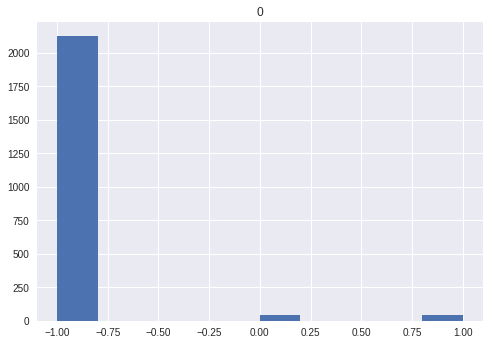

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_95_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_95_model_imb.classes_)
print(intrinsic_95_model_imb.score(X_train_mixed, y_train_mixed))

[0 1]
0.036601897876186174
CPU times: user 409 ms, sys: 193 ms, total: 602 ms
Wall time: 374 ms


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_95_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.7391304347826086
0.7000000000000001


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
fpr_int_95_imb, tpr_int_95_imb, thresholds_int_95_imb = roc_curve(y_test, y_pred)
auc_int_95_imb = auc(fpr_int_95_imb, tpr_int_95_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled , y, test_size=0.95, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]
# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)
# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (90, 16) (90,)
Unlabeled Train Set: (2125, 16) (2125,)
Test Set: (23, 16) (23,)
CPU times: user 8.54 ms, sys: 3.01 ms, total: 11.5 ms
Wall time: 11.9 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb83bdded0>]],
      dtype=object)

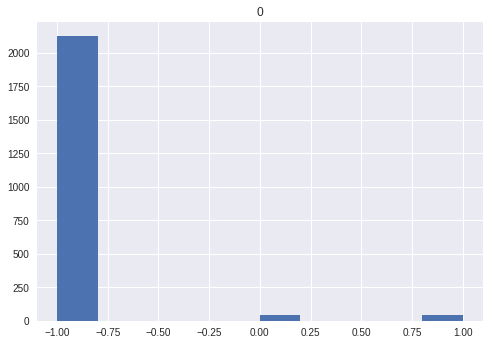

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_95_model_bal = LabelSpreading(alpha=0.001, max_iter=100, tol=0.01,kernel='knn',n_neighbors=19).fit(X_train_mixed, y_train_mixed)
print(intrinsic_95_model_bal.classes_)
print(intrinsic_95_model_bal.score(X_train_mixed, y_train_mixed))

[0 1]
0.036568848758465014
CPU times: user 359 ms, sys: 194 ms, total: 553 ms
Wall time: 350 ms


In [ ]:
y_pred = intrinsic_95_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.782608695652174
0.761904761904762


In [ ]:
fpr_int_95_bal, tpr_int_95_bal, thresholds_int_95_bal = roc_curve(y_test, y_pred)
auc_int_95_bal = auc(fpr_int_95_bal, tpr_int_95_bal)

# ROC Curves

### 1. Fully Supervised

<Figure size 432x288 with 0 Axes>

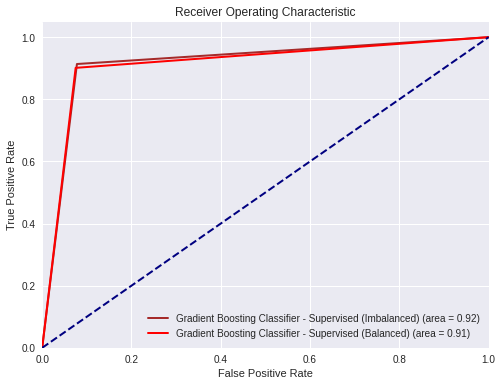

In [ ]:
plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_imb, tpr_imb, color='brown',
         lw=lw, label='Gradient Boosting Classifier - Supervised (Imbalanced) (area = %0.2f)' % roc_auc_imb)
plt.plot(fpr_bal, tpr_bal, color='red',
         lw=lw, label='Gradient Boosting Classifier - Supervised (Balanced) (area = %0.2f)' % roc_auc_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 2. 10% Unlabeled Data

<Figure size 432x288 with 0 Axes>

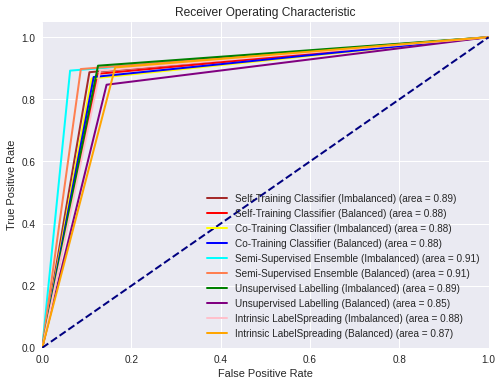

In [ ]:
fpr_st_10_imb, tpr_st_10_imb, auc_st_10_imb = st_10_imb_roc
fpr_st_10_bal, tpr_st_10_bal, auc_st_10_bal = st_10_bal_roc
fpr_ct_10_imb, tpr_ct_10_imb, auc_ct_10_imb = ct_10_imb_roc
fpr_ct_10_bal, tpr_ct_10_bal, auc_ct_10_bal = ct_10_bal_roc
fpr_sse_10_imb, tpr_sse_10_imb, auc_sse_10_imb = sse_10_imb_roc
fpr_sse_10_bal, tpr_sse_10_bal, auc_sse_10_bal = sse_10_bal_roc
fpr_usl_10_imb, tpr_usl_10_imb, auc_usl_10_imb = usl_10_imb_roc
fpr_usl_10_bal, tpr_usl_10_bal, auc_usl_10_bal = usl_10_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_10_imb, tpr_st_10_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_10_imb)
plt.plot(fpr_st_10_bal, tpr_st_10_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_10_bal)
plt.plot(fpr_ct_10_imb, tpr_ct_10_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_10_imb)
plt.plot(fpr_ct_10_bal, tpr_ct_10_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_10_bal)
plt.plot(fpr_sse_10_imb, tpr_sse_10_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_10_imb)
plt.plot(fpr_sse_10_bal, tpr_sse_10_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_10_bal)
plt.plot(fpr_usl_10_imb, tpr_usl_10_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_10_imb)
plt.plot(fpr_usl_10_bal, tpr_usl_10_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_10_bal)
plt.plot(fpr_int_10_imb, tpr_int_10_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_10_imb)
plt.plot(fpr_int_10_bal, tpr_int_10_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_10_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. 20% Unlabeled Data

<Figure size 432x288 with 0 Axes>

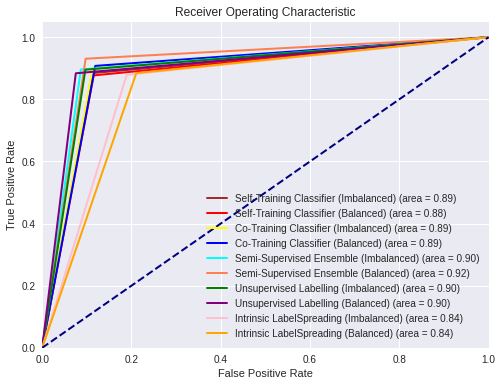

In [ ]:
fpr_st_20_imb, tpr_st_20_imb, auc_st_20_imb = st_20_imb_roc
fpr_st_20_bal, tpr_st_20_bal, auc_st_20_bal = st_20_bal_roc
fpr_ct_20_imb, tpr_ct_20_imb, auc_ct_20_imb = ct_20_imb_roc
fpr_ct_20_bal, tpr_ct_20_bal, auc_ct_20_bal = ct_20_bal_roc
fpr_sse_20_imb, tpr_sse_20_imb, auc_sse_20_imb = sse_20_imb_roc
fpr_sse_20_bal, tpr_sse_20_bal, auc_sse_20_bal = sse_20_bal_roc
fpr_usl_20_imb, tpr_usl_20_imb, auc_usl_20_imb = usl_20_imb_roc
fpr_usl_20_bal, tpr_usl_20_bal, auc_usl_20_bal = usl_20_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_20_imb, tpr_st_20_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_20_imb)
plt.plot(fpr_st_20_bal, tpr_st_20_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_20_bal)
plt.plot(fpr_ct_20_imb, tpr_ct_20_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_20_imb)
plt.plot(fpr_ct_20_bal, tpr_ct_20_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_20_bal)
plt.plot(fpr_sse_20_imb, tpr_sse_20_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_20_imb)
plt.plot(fpr_sse_20_bal, tpr_sse_20_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_20_bal)
plt.plot(fpr_usl_20_imb, tpr_usl_20_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_20_imb)
plt.plot(fpr_usl_20_bal, tpr_usl_20_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_20_bal)
plt.plot(fpr_int_20_imb, tpr_int_20_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_20_imb)
plt.plot(fpr_int_20_bal, tpr_int_20_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_20_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. 50% Unlabeled Data

<Figure size 432x288 with 0 Axes>

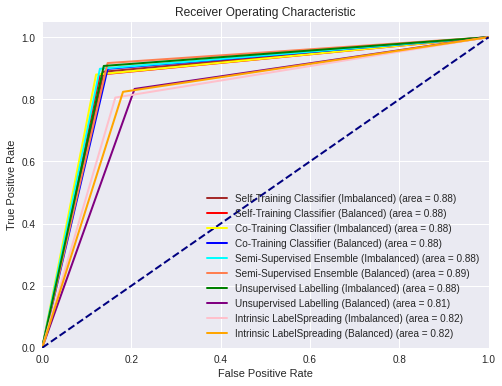

In [ ]:
fpr_st_50_imb, tpr_st_50_imb, auc_st_50_imb = st_50_imb_roc
fpr_st_50_bal, tpr_st_50_bal, auc_st_50_bal = st_50_bal_roc
fpr_ct_50_imb, tpr_ct_50_imb, auc_ct_50_imb = ct_50_imb_roc
fpr_ct_50_bal, tpr_ct_50_bal, auc_ct_50_bal = ct_50_bal_roc
fpr_sse_50_imb, tpr_sse_50_imb, auc_sse_50_imb = sse_50_imb_roc
fpr_sse_50_bal, tpr_sse_50_bal, auc_sse_50_bal = sse_50_bal_roc
fpr_usl_50_imb, tpr_usl_50_imb, auc_usl_50_imb = usl_50_imb_roc
fpr_usl_50_bal, tpr_usl_50_bal, auc_usl_50_bal = usl_50_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_50_imb, tpr_st_50_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_50_imb)
plt.plot(fpr_st_50_bal, tpr_st_50_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_50_bal)
plt.plot(fpr_ct_50_imb, tpr_ct_50_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_50_imb)
plt.plot(fpr_ct_50_bal, tpr_ct_50_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_50_bal)
plt.plot(fpr_sse_50_imb, tpr_sse_50_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_50_imb)
plt.plot(fpr_sse_50_bal, tpr_sse_50_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_50_bal)
plt.plot(fpr_usl_50_imb, tpr_usl_50_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_50_imb)
plt.plot(fpr_usl_50_bal, tpr_usl_50_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_50_bal)
plt.plot(fpr_int_50_imb, tpr_int_50_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_50_imb)
plt.plot(fpr_int_50_bal, tpr_int_50_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_50_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. 90% Unlabeled Data

<Figure size 432x288 with 0 Axes>

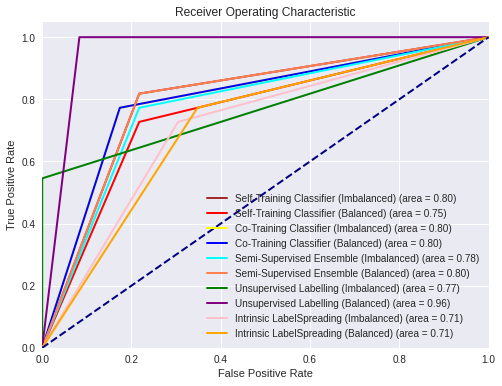

In [ ]:
fpr_st_90_imb, tpr_st_90_imb, auc_st_90_imb = st_90_imb_roc
fpr_st_90_bal, tpr_st_90_bal, auc_st_90_bal = st_90_bal_roc
fpr_ct_90_imb, tpr_ct_90_imb, auc_ct_90_imb = ct_90_imb_roc
fpr_ct_90_bal, tpr_ct_90_bal, auc_ct_90_bal = ct_90_bal_roc
fpr_sse_90_imb, tpr_sse_90_imb, auc_sse_90_imb = sse_90_imb_roc
fpr_sse_90_bal, tpr_sse_90_bal, auc_sse_90_bal = sse_90_bal_roc
fpr_usl_90_imb, tpr_usl_90_imb, auc_usl_90_imb = usl_90_imb_roc
fpr_usl_90_bal, tpr_usl_90_bal, auc_usl_90_bal = usl_90_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_90_imb, tpr_st_90_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_90_imb)
plt.plot(fpr_st_90_bal, tpr_st_90_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_90_bal)
plt.plot(fpr_ct_90_imb, tpr_ct_90_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_90_imb)
plt.plot(fpr_ct_90_bal, tpr_ct_90_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_90_bal)
plt.plot(fpr_sse_90_imb, tpr_sse_90_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_90_imb)
plt.plot(fpr_sse_90_bal, tpr_sse_90_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_90_bal)
plt.plot(fpr_usl_90_imb, tpr_usl_90_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_90_imb)
plt.plot(fpr_usl_90_bal, tpr_usl_90_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_90_bal)
plt.plot(fpr_int_90_imb, tpr_int_90_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_90_imb)
plt.plot(fpr_int_90_bal, tpr_int_90_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_90_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. 95% Unlabeled Data

<Figure size 432x288 with 0 Axes>

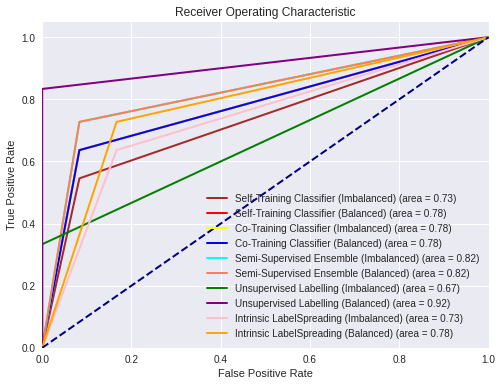

In [ ]:
fpr_st_95_imb, tpr_st_95_imb, auc_st_95_imb = st_95_imb_roc
fpr_st_95_bal, tpr_st_95_bal, auc_st_95_bal = st_95_bal_roc
fpr_ct_95_imb, tpr_ct_95_imb, auc_ct_95_imb = ct_95_imb_roc
fpr_ct_95_bal, tpr_ct_95_bal, auc_ct_95_bal = ct_95_bal_roc
fpr_sse_95_imb, tpr_sse_95_imb, auc_sse_95_imb = sse_95_imb_roc
fpr_sse_95_bal, tpr_sse_95_bal, auc_sse_95_bal = sse_95_bal_roc
fpr_usl_95_imb, tpr_usl_95_imb, auc_usl_95_imb = usl_95_imb_roc
fpr_usl_95_bal, tpr_usl_95_bal, auc_usl_95_bal = usl_95_bal_roc

plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_95_imb, tpr_st_95_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_95_imb)
plt.plot(fpr_st_95_bal, tpr_st_95_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_95_bal)
plt.plot(fpr_ct_95_imb, tpr_ct_95_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_95_imb)
plt.plot(fpr_ct_95_bal, tpr_ct_95_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_95_bal)
plt.plot(fpr_sse_95_imb, tpr_sse_95_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_95_imb)
plt.plot(fpr_sse_95_bal, tpr_sse_95_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_95_bal)
plt.plot(fpr_usl_95_imb, tpr_usl_95_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_95_imb)
plt.plot(fpr_usl_95_bal, tpr_usl_95_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_95_bal)
plt.plot(fpr_int_95_imb, tpr_int_95_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_95_imb)
plt.plot(fpr_int_95_bal, tpr_int_95_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_95_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()